In [3]:
import random
import numpy as np

SEED = 42

# Python
random.seed(SEED)

# Numpy
np.random.seed(SEED)

import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', task_type='binary', num_classes=None):
        """
        Unified Focal Loss class for binary, multi-class, and multi-label classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param alpha: Balancing factor, can be a scalar or a tensor for class-wise weights. If None, no class balancing is used.
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        :param task_type: Specifies the type of task: 'binary', 'multi-class', or 'multi-label'
        :param num_classes: Number of classes (only required for multi-class classification)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.task_type = task_type
        self.num_classes = num_classes

        # Handle alpha for class balancing in multi-class tasks
        if task_type == 'multi-class' and alpha is not None and isinstance(alpha, (list, torch.Tensor)):
            assert num_classes is not None, "num_classes must be specified for multi-class classification"
            if isinstance(alpha, list):
                self.alpha = torch.Tensor(alpha)
            else:
                self.alpha = alpha

    def forward(self, inputs, targets):
        """
        Forward pass to compute the Focal Loss based on the specified task type.
        :param inputs: Predictions (logits) from the model.
                       Shape:
                         - binary/multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size, num_classes)
        :param targets: Ground truth labels.
                        Shape:
                         - binary: (batch_size,)
                         - multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size,)
        """
        if self.task_type == 'binary':
            return self.binary_focal_loss(inputs, targets)
        elif self.task_type == 'multi-class':
            return self.multi_class_focal_loss(inputs, targets)
        elif self.task_type == 'multi-label':
            return self.multi_label_focal_loss(inputs, targets)
        else:
            raise ValueError(
                f"Unsupported task_type '{self.task_type}'. Use 'binary', 'multi-class', or 'multi-label'.")

    def binary_focal_loss(self, inputs, targets):
        """ Focal loss for binary classification. """
        # Ajustar dimensiones para TabNet
        if inputs.dim() > 1 and inputs.size(1) == 1:
            inputs = inputs.squeeze(1)
        
        probs = torch.sigmoid(inputs)
        targets = targets.float()

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weighting
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_class_focal_loss(self, inputs, targets):
        """ Focal loss for multi-class classification. """
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)

        # Convert logits to probabilities with softmax
        probs = F.softmax(inputs, dim=1)

        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute cross-entropy for each class
        ce_loss = -targets_one_hot * torch.log(probs)

        # Compute focal weight
        p_t = torch.sum(probs * targets_one_hot, dim=1)  # p_t for each sample
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided (per-class weighting)
        if self.alpha is not None:
            alpha_t = alpha.gather(0, targets)
            ce_loss = alpha_t.unsqueeze(1) * ce_loss

        # Apply focal loss weight
        loss = focal_weight.unsqueeze(1) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_label_focal_loss(self, inputs, targets):
        """ Focal loss for multi-label classification. """
        probs = torch.sigmoid(inputs)

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weight
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss



Iniciando entrenamiento FNN...
Epoch 0: Train Loss: 0.2707, Val Loss: 0.0968, F1: 0.8927
Epoch 20: Train Loss: 0.0934, Val Loss: 0.1203, F1: 0.8941
Early stopping en epoch 36
Umbral óptimo: 0.280
F1-Score: 0.9186

Reporte de clasificación:
              precision    recall  f1-score   support

           0     1.0000    0.3000    0.4615        20
           1     0.8495    1.0000    0.9186        79

    accuracy                         0.8586        99
   macro avg     0.9247    0.6500    0.6901        99
weighted avg     0.8799    0.8586    0.8263        99



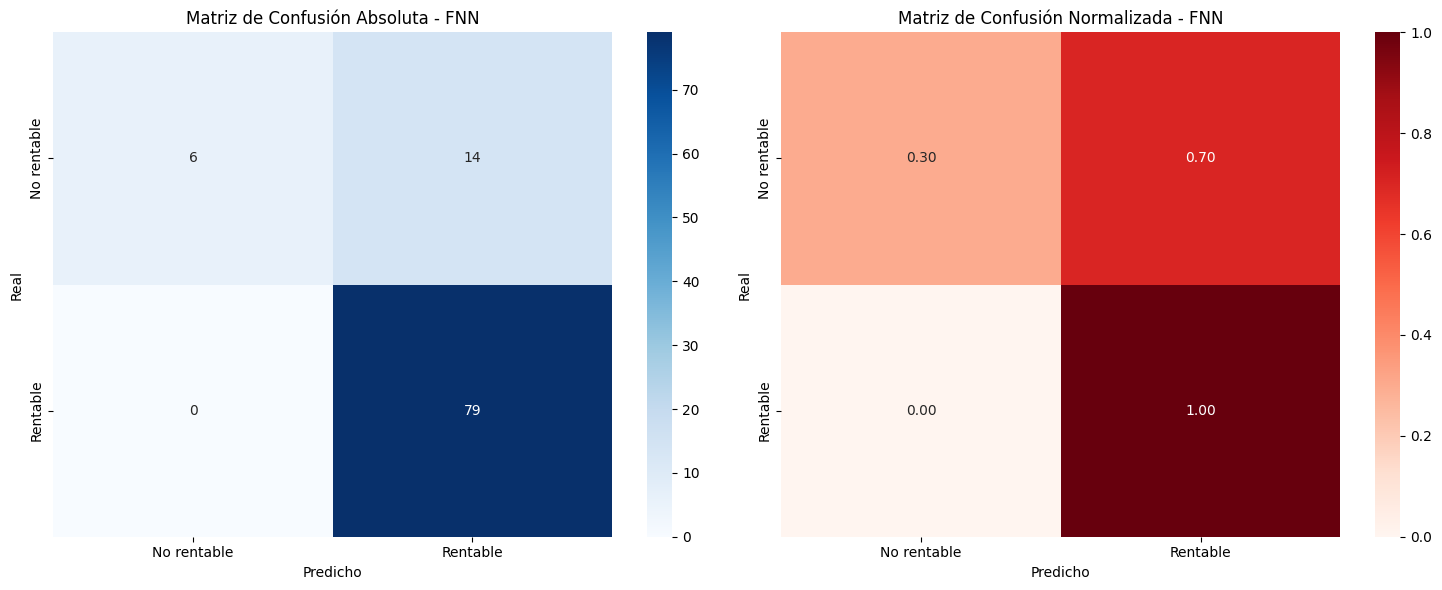


Métricas detalladas:
Sensibilidad (Recall clase positiva): 1.0000
Especificidad (Recall clase negativa): 0.3000
Precisión clase positiva: 0.8495
Precisión clase negativa: 1.0000


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class RegularizedFNN(nn.Module):
   def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rates=[0.5, 0.4, 0.3]):
       super(RegularizedFNN, self).__init__()
       
       layers = []
       prev_dim = input_dim
       
       for i, (hidden_dim, dropout_rate) in enumerate(zip(hidden_dims, dropout_rates)):
           layers.extend([
               nn.Linear(prev_dim, hidden_dim),
               nn.BatchNorm1d(hidden_dim),
               nn.ReLU(),
               nn.Dropout(dropout_rate)
           ])
           prev_dim = hidden_dim
       
       layers.append(nn.Linear(prev_dim, 1))
       self.network = nn.Sequential(*layers)
       
       # Weight initialization
       self.apply(self._init_weights)
   
   def _init_weights(self, m):
       if isinstance(m, nn.Linear):
           nn.init.xavier_uniform_(m.weight)
           nn.init.zeros_(m.bias)
   
   def forward(self, x):
       return self.network(x)

def train_model(model, train_loader, test_loader, focal_loss, epochs=200):
   optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
   scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
   
   best_f1 = 0
   patience_counter = 0
   patience_limit = 25
   
   for epoch in range(epochs):
       model.train()
       train_loss = 0
       
       for batch_x, batch_y in train_loader:
           batch_x, batch_y = batch_x.to(device), batch_y.to(device)
           
           optimizer.zero_grad()
           outputs = model(batch_x).squeeze()
           loss = focal_loss(outputs, batch_y)
           loss.backward()
           
           # Gradient clipping
           torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
           
           optimizer.step()
           train_loss += loss.item()
       
       # Validation
       model.eval()
       val_loss = 0
       all_preds = []
       all_targets = []
       
       with torch.no_grad():
           for batch_x, batch_y in test_loader:
               batch_x, batch_y = batch_x.to(device), batch_y.to(device)
               outputs = model(batch_x).squeeze()
               loss = focal_loss(outputs, batch_y)
               val_loss += loss.item()
               
               probs = torch.sigmoid(outputs)
               all_preds.extend(probs.cpu().numpy())
               all_targets.extend(batch_y.cpu().numpy())
       
       # Optimizar umbral y calcular F1
       precision, recall, thresholds = precision_recall_curve(all_targets, all_preds)
       f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
       optimal_f1 = np.max(f1_scores)
       
       scheduler.step(val_loss / len(test_loader))
       
       if epoch % 20 == 0:
           print(f'Epoch {epoch}: Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}, F1: {optimal_f1:.4f}')
       
       # Early stopping
       if optimal_f1 > best_f1:
           best_f1 = optimal_f1
           patience_counter = 0
           torch.save(model.state_dict(), 'best_model.pth')
       else:
           patience_counter += 1
           
       if patience_counter >= patience_limit:
           print(f'Early stopping en epoch {epoch}')
           break
   
   # Cargar mejor modelo
   model.load_state_dict(torch.load('best_model.pth'))
   return model

# Cargar y procesar datos
df_train = pd.read_csv("Train_Final.csv")
df_test = pd.read_csv("Test_Final.csv")

X_train = df_train.drop(columns=["Retble", "ID"], errors="ignore")
y_train = df_train["Retble"].map({"No rentable": 0, "Rentable": 1})

X_test = df_test.drop(columns=["Retble", "ID"], errors="ignore")
y_test = df_test["Retble"].map({"No rentable": 0, "Rentable": 1})

# Bootstrap balanceado
df_majority = df_train[df_train.Retble == "No rentable"]
df_minority = df_train[df_train.Retble == "Rentable"]

df_minority_upsampled = resample(df_minority, 
                              replace=True,
                              n_samples=int(len(df_majority) * 0.7),
                              random_state=SEED)

df_majority_downsampled = resample(df_majority,
                                replace=False,
                                n_samples=int(len(df_majority) * 0.6),
                                random_state=SEED)

df_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled])

X_balanced = df_balanced.drop(columns=["Retble", "ID"], errors="ignore")
y_balanced = df_balanced["Retble"].map({"No rentable": 0, "Rentable": 1})

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(X_test)

# Tensores
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_balanced.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Modelo y función de pérdida
input_dim = X_train_scaled.shape[1]
model = RegularizedFNN(input_dim).to(device)

# Focal Loss con parámetros correctos
focal_loss = FocalLoss(gamma=2.0, alpha=0.25, reduction="mean", task_type="binary")

# Entrenamiento
print("Iniciando entrenamiento FNN...")
model = train_model(model, train_loader, test_loader, focal_loss)

# Evaluación final
model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
   for batch_x, _ in test_loader:
       batch_x = batch_x.to(device)
       outputs = model(batch_x).squeeze()
       probs = torch.sigmoid(outputs)
       all_probs.extend(probs.cpu().numpy())

# Optimizar umbral
precision, recall, thresholds = precision_recall_curve(y_test, all_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

y_pred = (np.array(all_probs) >= optimal_threshold).astype(int)

print(f"Umbral óptimo: {optimal_threshold:.3f}")
print(f"F1-Score: {f1_scores[optimal_idx]:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
          xticklabels=["No rentable", "Rentable"],
          yticklabels=["No rentable", "Rentable"])
ax1.set_title("Matriz de Confusión Absoluta - FNN")
ax1.set_xlabel("Predicho")
ax1.set_ylabel("Real")

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds', ax=ax2,
          xticklabels=["No rentable", "Rentable"],
          yticklabels=["No rentable", "Rentable"])
ax2.set_title("Matriz de Confusión Normalizada - FNN")
ax2.set_xlabel("Predicho")
ax2.set_ylabel("Real")

plt.tight_layout()
plt.savefig("fnn_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Métricas detalladas
print(f"\nMétricas detalladas:")
print(f"Sensibilidad (Recall clase positiva): {cm[1,1]/(cm[1,0]+cm[1,1]):.4f}")
print(f"Especificidad (Recall clase negativa): {cm[0,0]/(cm[0,0]+cm[0,1]):.4f}")
print(f"Precisión clase positiva: {cm[1,1]/(cm[0,1]+cm[1,1]):.4f}")
print(f"Precisión clase negativa: {cm[0,0]/(cm[1,0]+cm[0,0]):.4f}")



In [5]:
import torch

# Guardar el modelo final
torch.save(model.state_dict(), 'final_fnn_model.pth')
# Guardar el escalador
torch.save(scaler, 'scaler.pth')